In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:

train_df = pd.read_csv("heart_train.csv")  
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_df_encoded = train_df.copy()
le = LabelEncoder()
cols_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in cols_to_encode:
    train_df_encoded[col] = le.fit_transform(train_df_encoded[col])


In [4]:
X = train_df_encoded.drop('HeartDisease', axis=1)
y = train_df_encoded['HeartDisease']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(62, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


In [8]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train, epochs=100, batch_size=16,
    validation_split=0.2, callbacks=[early_stop], verbose=0
)


In [10]:
# Get predicted probabilities and class predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [11]:
# Resultss
acc = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
report = classification_report(y_test, y_pred_class)
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.8190
F1 Score: 0.8319

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        99
           1       0.85      0.81      0.83       122

    accuracy                           0.82       221
   macro avg       0.82      0.82      0.82       221
weighted avg       0.82      0.82      0.82       221



In [12]:
# Load test data 
test_df = pd.read_csv("heart_test.csv")

# Store ID column if it exists
if "id" in test_df.columns:
    ids = test_df["id"]
else:
    ids = pd.Series(range(len(test_df)))  # fallback if no ID column

# Encode categorical columns (ensure same columns as training)
test_df_encoded = test_df.copy()
for col in cols_to_encode:
    test_df_encoded[col] = le.fit_transform(test_df_encoded[col].astype(str))

# Scale features (must drop ID column if it exists)
X_final_test = test_df_encoded.drop(columns=["id"], errors="ignore")
X_final_test = scaler.transform(X_final_test)

# Predict using trained MLP model
test_pred = model.predict(X_final_test)
test_pred_class = (test_pred > 0.5).astype("int32").ravel()

# Create submission DataFrame
submission = pd.DataFrame({
    "id": ids,
    "HeartDisease": test_pred_class
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("file saved ")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
file saved 


In [13]:
# Check the results of trained data
train_df.head(9)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,1
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up,0
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat,1
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat,1
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
5,49,F,ATA,134,271,0,Normal,162,N,0.0,Flat,0
6,64,M,ASY,144,0,0,ST,122,Y,1.0,Flat,1
7,47,F,ATA,140,257,0,Normal,135,N,1.0,Up,0
8,52,F,ATA,120,210,0,Normal,148,N,0.0,Up,0


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


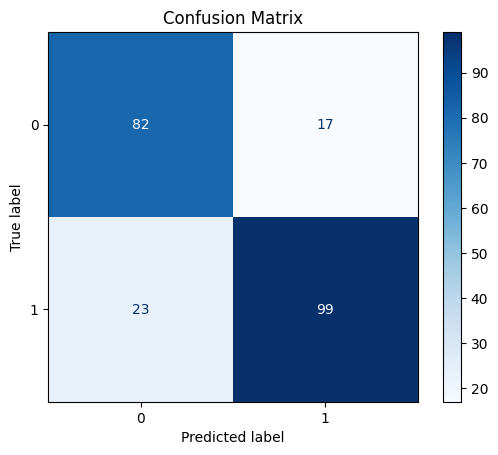

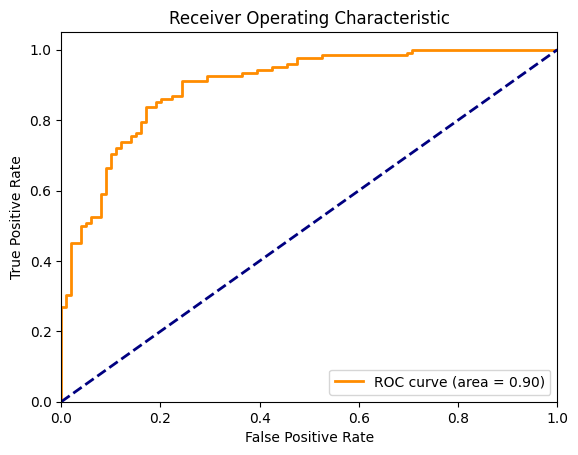

In [14]:
y_pred_prob = model.predict(X_test).ravel()
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


In [15]:
# Save the trained model to a .h5 file
model.save('heart_model.h5')
